Binary Classification using BIO BERT
This code is modified and adapted based on the repository
https://github.com/perkdrew/advanced-nlp/blob/master/BioBERT/classification/biobert_classification.ipynb

Get the BioBERT Weights

In [1]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt


--2022-05-30 22:31:22--  https://docs.google.com/uc?export=download&confirm=t&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD
Resolving docs.google.com (docs.google.com)... 142.251.8.101, 142.251.8.102, 142.251.8.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.8.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-20-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hqdoq12gcdtcs5adji2qe67l15751q5v/1653949875000/13799006341648886493/*/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download [following]
--2022-05-30 22:31:22--  https://doc-10-20-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hqdoq12gcdtcs5adji2qe67l15751q5v/1653949875000/13799006341648886493/*/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download
Resolving doc-10-20-docs.googleusercontent.com (doc-10-20-docs.googleusercontent.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to doc-10-20-docs.googleusercontent.com (doc-10-20-do

In [2]:
!tar -xzf biobert_weights
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.index  vocab.txt
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta


### Install required libraries

In [3]:
!pip install pytorch_transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 53.2 MB/s 
     |████████████████████████████████| 880 kB 50.0 MB/s 
     |████████████████████████████████| 132 kB 71.4 MB/s 
     |████████████████████████████████| 79 kB 9.6 MB/s 
     |████████████████████████████████| 8.8 MB 61.8 MB/s 
     |████████████████████████████████| 138 kB 78.7 MB/s 
     |████████████████████████████████| 127 kB 75.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=1ce244a335255c6da3747189b2b21e99178c2c4a537d8297b62eb545c07edd14
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled

In [4]:
# install BERT
!pip install pytorch_pretrained_bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 4.3 MB/s 
     |████████████████████████████████| 90 kB 8.2 MB/s 


In [22]:

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from cf_matrix import make_confusion_matrix 
import dfutilities
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# BERT imports
import torch
from pytorch_transformers import BertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

In [6]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

#Create the model using BioBERT Pretrained Weights

In [7]:
!transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin


Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

Converting TensorFlow checkpoint from /content/biobert_v1.1_pubmed/model.ckpt-1000000
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
Loading TF weight bert/embeddings/word_embeddings with shape 

In [8]:
!ls biobert_v1.1_pubmed/
!mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt
config.json				model.ckpt-1000000.meta
model.ckpt-1000000.data-00000-of-00001	pytorch_model.bin
model.ckpt-1000000.index		vocab.txt


In [9]:

model = BertModel.from_pretrained('biobert_v1.1_pubmed')

### LOAD DATA

In [10]:
train_path = "/content/PredictedLabels_WithAL.csv"
test_path = "/content/ManualAnnotatedData.csv"
dfHandler = dfutilities.dfUtil()
df_train,df_test,log = dfHandler.handle_data(train_path,test_path)
log

['Length of Train Dataset : 60123',
 'Length of Test Dataset : 3200',
 'Number of Null Values in Train Dataset : 0',
 'Number of Null Values in Test Dataset : 0']

### Tokenize the data

In [11]:
description = list(df_train['CleanText'])

tokenizer = BertTokenizer.from_pretrained('biobert_v1.1_pubmed', do_lower_case=True)

tokenized_texts = list(map(lambda t: ['[CLS]']+tokenizer.tokenize(t)+['[SEP]'] , description))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', '.', '.', '.', 'and', 'there', 'is', 'potential', 'risk', 'of', 'f', '##etal', 'harm', 'from', 'te', '##ri', '##f', '##lu', '##no', '##mi', '##de', 'per', 'pre', '##s', '##cribing', 'information', 'so', 'its', 'important', 'that', 'ch', '##els', '##ea', 'continuous', 'her', 'highly', 'effective', 'and', 'reliable', 'con', '##tra', '##ception', '.', 'te', '##ri', '##f', '##lu', '##no', '##mi', '##de', 'use', 'requires', 'liver', 'enzyme', 'monitoring', 'for', 'he', '##pa', '##to', '##to', '##xi', '##city', '.', '[SEP]']


In [12]:
classes = list(df_train['Label'].astype(int))

In [13]:
MAX_LEN = 100

input_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokenized_texts)),
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [14]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [15]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [16]:
batch_size = 16

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, classes, 
                                                            random_state=2020, test_size=0.25)

In [17]:
len(validation_inputs)

15031

In [18]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.25)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [19]:
model = BertForSequenceClassification.from_pretrained("biobert_v1.1_pubmed", num_labels=2)#binary classification
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.09522832695320585


Epoch:  25%|██▌       | 1/4 [11:09<33:27, 669.05s/it]

Validation Accuracy: 0.9705262158054712
Train loss: 0.045959399152165493


Epoch:  50%|█████     | 2/4 [22:17<22:17, 668.69s/it]

Validation Accuracy: 0.96893047112462
Train loss: 0.020181096831929247


Epoch:  75%|███████▌  | 3/4 [33:33<11:11, 671.85s/it]

Validation Accuracy: 0.9679996200607903
Train loss: 0.012937179480238505


Epoch: 100%|██████████| 4/4 [44:41<00:00, 670.41s/it]

Validation Accuracy: 0.966270896656535


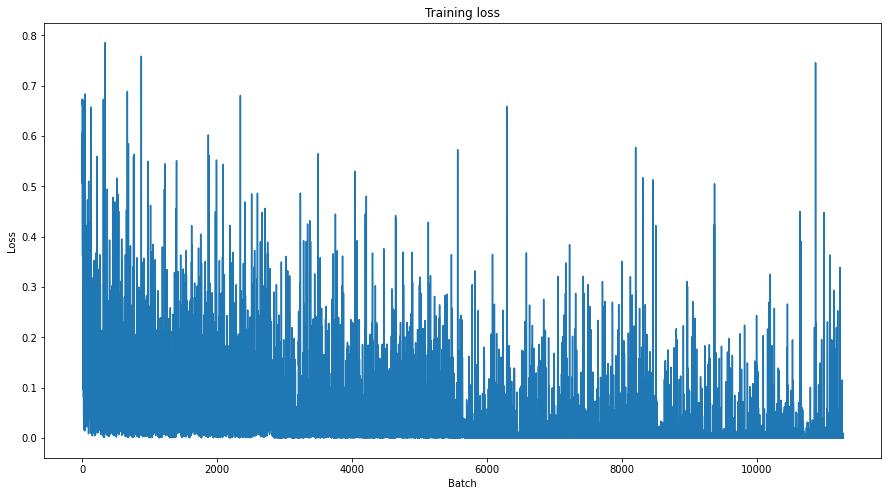

In [24]:
#BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = ples = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

### Evaluate the model on test data

In [25]:
descr = df_test['CleanText'].to_list()
tokenized_texts = list(map(lambda t: ['[CLS]']+tokenizer.tokenize(t)+['[SEP]'] , descr))
MAX_LEN = 100

input_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokenized_texts)),
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [26]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [27]:

classes = df_test['Label'].to_list()

In [28]:
# Convert all of our data into torch tensors, the required datatype for our model

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(classes)
test_masks = torch.tensor(attention_masks)

# Create an iterator of our data with torch DataLoader 
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [29]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [30]:
# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)


  #logits = outputs[0]
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  #logits = outputs.cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [31]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [33]:
ypred = flat_predictions 
ytrue = flat_true_labels

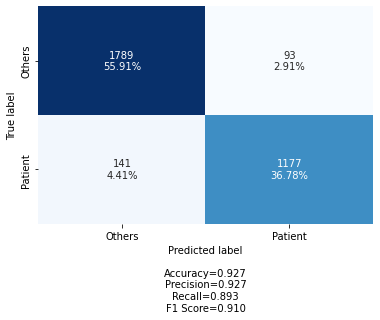

In [34]:
categories = ['Others', 'Patient']
cm = confusion_matrix(ypred,ytrue)
make_confusion_matrix(cm, cbar=False,
                      #group_names=labels,
                      categories=categories, 
                      cmap='Blues')